<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Part 2 - Computing the PDF**

**A) Theory**

Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, the CDF obtained in **Part 1** is clearly discontinuous and we must therefore use a weak derivative. To this end we choose to recover the PDF via a projection as this requires less regularity. To do so we define the function space $V_f $ of $f(y)$ to be
\begin{equation*}
    f \in V_f \subset H^1(\Omega_Y), \quad \text{where} \quad f:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \left\{ \int f^2 dy < \infty, \int |\nabla f|^2 dy < \infty \right\},
\end{equation*}
thus allowing for weak derivatives, followed by a set of basis functions $V_f = span\{\varphi_i(y)\}$ such that
\begin{equation*}
    f(y) = \sum_i f_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \varphi_e \in V_{e},
\end{equation*}
which can be integrated by parts in order to put the derivative onto $\varphi_e$ thus resulting in a boundary flux
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = -\int_{e} F(y) \partial_y \varphi_e \; dy + \int_{\partial e} F \varphi_e \cdot \vec{n}_e \; dS, \quad \text{where} \quad \varphi_e \in V_{e},
\end{equation*}
and $\vec{n}_e$ is the outward pointing unit normal. At the interior element facets $F_+,F_-$ is used to denote the value of $F$ approaching from the right/left. Summing the contribution of all the elements $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \sum_e \int_e      F (\varphi_e \cdot \vec{n}_e) \; dS \\
                                   & + \int_{\Gamma_{max(y)}} F v \cdot \vec{n} \; ds \\
                                   & + \int_{\Gamma_{min(y)}} F v \cdot \vec{n} \; ds \quad \forall v \in V_{f},
\end{align}
where the terms on the right hand side correspond to the cell integral, the integral over the set of all interior facets and the integral at the right and left boundaries respectively. Applying the boundary conditions to the CDF and rewriting the integral over the interior facets in terms of the jump we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \sum_e \varphi_e(F_+  - F_-) dS \\
                                   & + v(y=y_{max}) \quad \forall v \in V_{f}.
\end{align}

In **Part 1** a discontinuous piecewise linear function space (DG1) for $F(y)$ was justified by the need to maintain a non-decreasing and right-continuous function, which can be achieved by applying a slope limiter more easily for DG1 than for other higher order elements. Although this would be also guaranteed by choosing the space of piece-wise constant discontinuous functions DG0, the cell integral and the boundary terms in the previous equation would cancel, meaning that an additional approximation would need to be introduced in order to recover the PDF at these points. By choosing DG1 this issue is avoided.

Motivated by the need to take a weak derivative in order to recover the PDF $f(y)$ we chose a piecewise linear function space $V_f$ for $f(y)$ that is continuous between elements (the finite element space CG1). Strictly speaking $f(y) \subset L^1(\Omega_Y)$ and for this reason a large class of PDFs are neither bounded nor have weak derivatives ([Devroye, L. & Györfi, L. (1985)](https://www.szit.bme.hu/~gyorfi/L1bookBW.pdf)). As such the fact that this projection operation assumes $f \subset H^1(\Omega_Y)$ implies that the PDF computed is valid only for a narrow class of functions and should thus be seen as a means for graphing the PDF. 

**B) Numerical implementation**

To demonstrate our method of recovering the CDF from the PDF we will make use of the CDF $F(y)$ and its associated mesh from **Part 1**. To simplify the presentation we use the *NumDF* library (imported below) which implements the methods used in **Part 1**. 

In [1]:
from numdf import Ptp
import numpy as np
from firedrake import *

We begin by creating an instance of the *Ptp* class by specify the physical domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 a discontinuous piecewise linear 'DG1' function space is selected by default for the CDF.

In [2]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (0, 2*np.pi)}, Omega_Y = {'Y': (0, 1)}, n_elements=200)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain and generate its CDF by calling the fit method.

In [3]:
# Extract the coordinates
x1 = ptp.x_coords()
density = ptp.fit(Y = sin(x1)**2, quadrature_degree=4000)

Using the density object we can then plot the CDF.

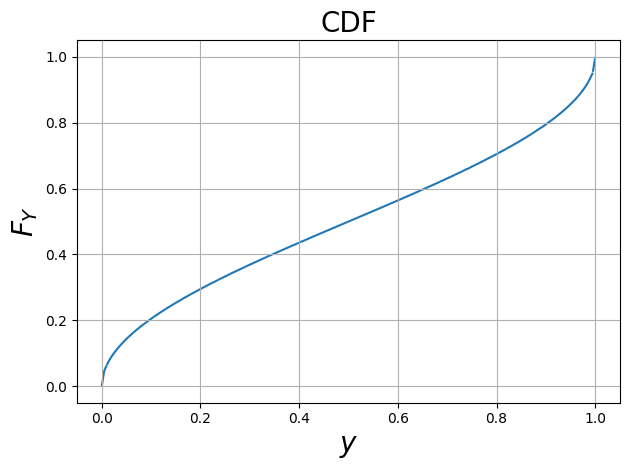

In [4]:
density.plot('CDF')

Reusing the mesh constructed for the CDF $F(y)$ we specify a piecewise linear function space $V_f$ for $f(y)$ that is continuous between elements.

In [5]:
# Grab the CDF F and its associated mesh m_y
F   = density.cdf
m_y = ptp.V_F.mesh()

# Define a function space
V_f = FunctionSpace(mesh=m_y,family="CG",degree=1);

u = TrialFunction(V_f)
v = TestFunction(V_f)

# Define the variational forms for the previous equation
a =  inner(u,v) * dx

L_cell = -inner(F,v.dx(0)) * dx(degree=2000) 
L_int = (F('+')*v('+') - F('-')*v('-'))*dS
L_ext = F*v*ds(2) - F*v*ds(1)  # Can get rid of the second term as its zero and simplify the first as F=1

L = L_cell + L_int + L_ext

# Solve for the pdf f
f = Function(V_f)
solve(a == L, f)

We then plot the PDF below.

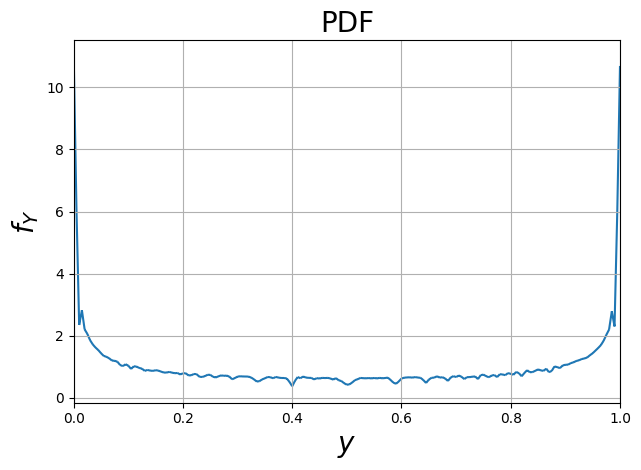

In [6]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

plot(f,num_sample_points=50)
plt.title(r'PDF',fontsize=20)
plt.ylabel(r'$f_Y$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.tight_layout()
plt.xlim([0,1])
plt.grid()
plt.show()

As the PDF is less regular than the CDF, a higher order quadrature and a larger number of elements is required to attempt to converge to the true solution. Near $y=0$ and $y=1$ however, the magnitude of $f$ increases with the number of elements thus highlighting that the function is not bounded at these points. This is a consequence of the aforementioned fact that typically $f \subset L^1(\Omega_Y)$.